# Homework 4

#### [문제 1] 수업 자료에서 제시하고 있는 다음 코드들을 Backend AI로 옮겨 실행하고 각 결과를 Backend AI 내에 잘 정리하여 제시하기

##### _01_code/_15_lstm_and_its_application/g_crypto_currency_regression_train_lstm.py

In [4]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from datetime import datetime
import os
import wandb
from pathlib import Path

# BASE_PATH = str(Path(__file__).resolve().parent.parent.parent) # BASE_PATH: /Users/yhhan/git/link_dl
BASE_PATH = str(Path.cwd().parent.parent.parent)  # 현재 디렉토리 기준으로 부모 디렉토리 이동
print(BASE_PATH)

/data/2_data_server/nlp-05/KOREATECH/2024-2_DL/link_dl


In [5]:
import sys
sys.path.append(BASE_PATH)

In [6]:
# CURRENT_FILE_PATH = os.path.dirname(os.path.abspath(__file__))
CURRENT_FILE_PATH = str(Path.cwd())
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

from _01_code._15_lstm_and_its_application.f_arg_parser import get_parser
from _01_code._14_rnn.g_rnn_trainer import RegressionTrainer
from _01_code._03_real_world_data_to_tensors.p_cryptocurrency_dataset_dataloader import get_cryptocurrency_data, \
  CryptoCurrencyDataset

In [54]:
import pandas as pd

def get_cryptocurrency_data(
    sequence_size=10,          # 시퀀스 길이 (몇 일치 데이터를 볼지)
    validation_size=100,       # 검증 데이터셋 크기
    test_size=10,             # 테스트 데이터셋 크기
    target_column='Close',     # 예측할 대상 컬럼 (기본값: 종가)
    y_normalizer=1.0e7,       # y값 정규화를 위한 스케일링 팩터
    is_regression=True        # True: 회귀 문제, False: 분류 문제
):
    # BASE_PATH 기준으로 비트코인 데이터 파일 경로 설정
    # btc_krw_path = os.path.join(BASE_PATH, "_00_data", "k_cryptocurrency", "BTC_KRW.csv")
    btc_krw_path = os.path.join(os.getcwd(), "BTC_KRW.csv")
    df = pd.read_csv(btc_krw_path)
    row_size = len(df)
    # ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    date_list = df['Date']

    df = df.drop(columns=['Date'])

    data_size = row_size - sequence_size
    train_size = data_size - (validation_size + test_size)
    #################################################################################################

    row_cursor = 0

    X_train_list = []
    y_train_regression_list = []
    y_train_classification_list = []
    y_train_date = []
    for idx in range(0, train_size):
        sequence_data = df.iloc[idx: idx + sequence_size].values  # sequence_data.shape: (sequence_size, 5)
        X_train_list.append(torch.from_numpy(sequence_data))
        y_train_regression_list.append(df.iloc[idx + sequence_size][target_column])
        y_train_classification_list.append(
        1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
        )
        y_train_date.append(date_list[idx + sequence_size])
        row_cursor += 1

    X_train = torch.stack(X_train_list, dim=0).to(torch.float)
    y_train_regression = torch.tensor(y_train_regression_list, dtype=torch.float32) / y_normalizer
    y_train_classification = torch.tensor(y_train_classification_list, dtype=torch.int64)

    m = X_train.mean(dim=0, keepdim=True)
    s = X_train.std(dim=0, keepdim=True)
    X_train = (X_train - m) / s

    #################################################################################################

    X_validation_list = []
    y_validation_regression_list = []
    y_validation_classification_list = []
    y_validation_date = []
    for idx in range(row_cursor, row_cursor + validation_size):
        sequence_data = df.iloc[idx: idx + sequence_size].values  # sequence_data.shape: (sequence_size, 5)
        X_validation_list.append(torch.from_numpy(sequence_data))
        y_validation_regression_list.append(df.iloc[idx + sequence_size][target_column])
        y_validation_classification_list.append(
        1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
        )
        y_validation_date.append(date_list[idx + sequence_size])
        row_cursor += 1

    X_validation = torch.stack(X_validation_list, dim=0).to(torch.float)
    y_validation_regression = torch.tensor(y_validation_regression_list, dtype=torch.float32) / y_normalizer
    y_validation_classification = torch.tensor(y_validation_classification_list, dtype=torch.int64)

    X_validation = (X_validation - m) / s
    #################################################################################################

    X_test_list = []
    y_test_regression_list = []
    y_test_classification_list = []
    y_test_date = []
    for idx in range(row_cursor, row_cursor + test_size):
        sequence_data = df.iloc[idx: idx + sequence_size].values  # sequence_data.shape: (sequence_size, 5)
        X_test_list.append(torch.from_numpy(sequence_data))
        y_test_regression_list.append(df.iloc[idx + sequence_size][target_column])
        y_test_classification_list.append(
        1 if df.iloc[idx + sequence_size][target_column] > df.iloc[idx + sequence_size - 1][target_column] else 0
        )
        y_test_date.append(date_list[idx + sequence_size])
        row_cursor += 1

    X_test = torch.stack(X_test_list, dim=0).to(torch.float)
    y_test_regression = torch.tensor(y_test_regression_list, dtype=torch.float32) / y_normalizer
    y_test_classification = torch.tensor(y_test_classification_list, dtype=torch.int64)

    X_test = (X_test - m) / s

    if is_regression:
        return (
        X_train, X_validation, X_test,
        y_train_regression, y_validation_regression, y_test_regression,
        y_train_date, y_validation_date, y_test_date
        )
    else:
        return (
        X_train, X_validation, X_test,
        y_train_classification, y_validation_classification, y_test_classification,
        y_train_date, y_validation_date, y_test_date
        )

In [8]:
def get_btc_krw_data(sequence_size=10, validation_size=100, test_size=10, is_regression=True):
   # 비트코인 가격 데이터를 학습/검증/테스트 세트로 분리하는 함수
   
   # 파라미터 설명:
   # sequence_size: 입력 시퀀스의 길이 (몇 일치 데이터를 보고 예측할지)
   # validation_size: 검증 데이터셋의 크기
   # test_size: 테스트 데이터셋의 크기 
   # is_regression: True이면 회귀 문제, False이면 분류 문제로 처리

   # get_cryptocurrency_data 함수를 호출하여 데이터 분할
   X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
       = get_cryptocurrency_data(
           sequence_size=sequence_size,
           validation_size=validation_size, 
           test_size=test_size,
           target_column='Close',  # 종가를 예측 타겟으로 사용
           y_normalizer=1.0e7,     # y값을 정규화하기 위한 스케일링 팩터
           is_regression=is_regression
       )

   # 반환되는 데이터 형태:
   # X_train.shape: [3212, 10, 5] - 3212개 샘플, 각 10일치 시퀀스, 5개 특성
   # X_validation.shape: [100, 10, 5] - 100개 검증 샘플
   # X_test.shape: [10, 10, 5] - 10개 테스트 샘플
   # y_train.shape: [3212] - 각 시퀀스에 대한 타겟값
   # y_validation.shape: [100]
   # y_test.shape: [10]

   # CryptoCurrencyDataset 클래스를 사용하여 PyTorch Dataset 객체 생성
   train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
   validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
   test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

   # DataLoader를 사용하여 배치 처리를 위한 이터레이터 생성
   train_data_loader = DataLoader(
       dataset=train_crypto_currency_dataset, 
       batch_size=wandb.config.batch_size,  # wandb에 설정된 배치 크기 사용
       shuffle=True  # 매 에폭마다 데이터 순서를 섞음
   )
   
   validation_data_loader = DataLoader(
       dataset=validation_crypto_currency_dataset,
       batch_size=wandb.config.batch_size,
       shuffle=True
   )
   
   test_data_loader = DataLoader(
       dataset=test_crypto_currency_dataset,
       batch_size=len(test_crypto_currency_dataset),  # 테스트는 전체 데이터를 한 번에 처리
       shuffle=True
   )

   # 생성된 DataLoader 객체들 반환
   return train_data_loader, validation_data_loader, test_data_loader

In [9]:
def get_model():
   # LSTM과 FCN을 결합한 시계열 예측 모델 클래스 정의
   class MyModel(nn.Module):
       def __init__(self, n_input, n_output):
           # n_input: 입력 특성의 수 (여기서는 5개: Open, High, Low, Close, Volume 등)
           # n_output: 출력값의 수 (여기서는 1개: 다음 날의 종가 예측)
           super().__init__()

           # LSTM 레이어 정의
           self.lstm = nn.LSTM(
               input_size=n_input,     # 입력 특성 수
               hidden_size=128,        # LSTM의 은닉 상태 크기
               num_layers=2,           # LSTM 레이어 수 (2개의 LSTM 레이어를 쌓음)
               batch_first=True        # 입력 텐서의 형태가 [batch_size, sequence_length, n_input]
           )

           # 완전연결층(Fully Connected Layer) 정의
           self.fcn = nn.Linear(
               in_features=128,        # LSTM의 은닉 상태 크기와 동일
               out_features=n_output   # 출력값의 수 (예측값)
           )

       def forward(self, x):
           # x의 예상되는 입력 shape: [batch_size, sequence_length, n_input]
           
           # LSTM 레이어 통과
           # x: LSTM의 출력값, hidden: 마지막 은닉 상태와 셀 상태
           x, hidden = self.lstm(x)
           # x의 shape: [batch_size, sequence_length, hidden_size]

           # 마지막 시점의 출력만 선택
           x = x[:, -1, :]  
           # x의 shape: [batch_size, hidden_size]
           # [:, -1, :]: 모든 배치(-1 인덱스)의 마지막 시점 출력을 선택

           # 완전연결층을 통과시켜 최종 예측값 생성
           x = self.fcn(x)
           # x의 shape: [batch_size, n_output]

           return x

   # 모델 인스턴스 생성
   # n_input=5: 입력 특성 5개
   # n_output=1: 예측값 1개 (다음 날의 종가)
   my_model = MyModel(n_input=5, n_output=1)

   return my_model

In [10]:
def main(args):
   # 현재 시간을 문자열로 변환하여 실험 구분에 사용
   run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

   # wandb에서 추적할 하이퍼파라미터 설정
   config = {
       'epochs': args.epochs,                # 총 학습 에폭 수
       'batch_size': args.batch_size,        # 배치 크기
       'validation_intervals': args.validation_intervals,  # 검증을 수행할 간격
       'learning_rate': args.learning_rate,  # 학습률
       'early_stop_patience': args.early_stop_patience,  # 조기 종료를 위한 인내심
       'early_stop_delta': args.early_stop_delta,        # 조기 종료를 위한 최소 개선값
       'weight_decay': args.weight_decay     # L2 정규화 계수
   }

   # Weights & Biases 초기화
   project_name = "lstm_regression_btc_krw"
   wandb.init(
       mode="online" if args.wandb else "disabled",  # wandb 사용 여부 설정
       project=project_name,                         # 프로젝트 이름
       notes="btc_krw experiment with lstm",        # 실험 노트
       tags=["lstm", "regression", "btc_krw"],      # 실험 태그
       name=run_time_str,                           # 실험 이름(현재 시간 기반)
       config=config                                # 설정된 하이퍼파라미터
   )
   # 입력 인자와 wandb 설정 출력
   print(args)
   print(wandb.config)

   # 데이터 로더 생성 (테스트 데이터 로더는 현재 사용하지 않음)
   train_data_loader, validation_data_loader, _ = get_btc_krw_data()
   
   # GPU 사용 가능 여부 확인 및 디바이스 설정
   device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
   print(f"Training on device {device}.")

   # 모델 생성 및 지정된 디바이스로 이동
   model = get_model()
   model.to(device)

   # Adam 옵티마이저 설정
   # learning_rate와 weight_decay는 wandb config에서 가져옴
   optimizer = optim.Adam(
       model.parameters(), 
       lr=wandb.config.learning_rate, 
       weight_decay=wandb.config.weight_decay
   )

   # 회귀 학습을 위한 트레이너 객체 생성
   regression_trainer = RegressionTrainer(
       project_name,              # 프로젝트 이름
       model,                     # 학습할 모델
       optimizer,                 # 옵티마이저
       train_data_loader,         # 학습 데이터 로더
       validation_data_loader,    # 검증 데이터 로더
       None,                      # 테스트 데이터 로더(사용하지 않음)
       run_time_str,             # 실험 구분을 위한 시간 문자열
       wandb,                     # wandb 객체
       device,                    # 학습 디바이스
       CHECKPOINT_FILE_PATH       # 체크포인트 저장 경로
   )
   
   # 학습 실행
   regression_trainer.train_loop()

   # wandb 실험 종료
   wandb.finish()

In [11]:
if __name__ == "__main__":
  parser = get_parser()
  # args = parser.parse_args()
  args = parser.parse_args(['--wandb'])
  main(args)

  # python _01_code/_11_lstm_and_its_application/f_crypto_currency_regression_train_lstm.py --wandb

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: chosuyeon (chosuyeon-korea-university-of-technology-and-education). Use `wandb login --relogin` to force relogin


Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=0.0001, weight_decay=0.0, validation_intervals=30, early_stop_patience=30, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0.0}
Training on device cuda:0.
[Epoch   1] T_loss: 10.35280, V_loss: 80.13316, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.004
[Epoch  30] T_loss: 6.55852, V_loss: 50.38114, V_loss decreased (80.13316 --> 50.38114). Saving model... | T_time: 00:00:01, T_speed: 0.407
[Epoch  60] T_loss: 0.72139, V_loss: 11.70491, V_loss decreased (50.38114 --> 11.70491). Saving model... | T_time: 00:00:01, T_speed: 0.068
[Epoch  90] T_loss: 0.37704, V_loss: 7.67111, V_loss decreased (11.70491 --> 7.67111). Saving model... | T_time: 00:00:02, T_speed: 0.114
[Epoch 120] T_loss: 0.25764, V_loss: 5.39041, V_loss decreased (7.67111 --> 5.39041). Saving model... | T_time: 00

Epoch,▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██████
Training loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁█▁▁▁
Validation loss,█▆▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,4080
Training loss,0.01005
Training speed (epochs/sec.),5.38474
Validation loss,0.50146


##### _01_code/_15_lstm_and_its_application/h_crypto_currency_regression_test_lstm.py

In [12]:
import torch
import wandb
from matplotlib import pyplot as plt
from datetime import datetime
import os
from pathlib import Path

# BASE_PATH = str(Path(__file__).resolve().parent.parent.parent) # BASE_PATH: /Users/yhhan/git/link_dl
BASE_PATH = str(Path.cwd().parent.parent.parent)  # 현재 디렉토리 기준으로 부모 디렉토리 이동
print(BASE_PATH)

/data/2_data_server/nlp-05/KOREATECH/2024-2_DL/link_dl


In [13]:
import sys
sys.path.append(BASE_PATH)

In [14]:
# CURRENT_FILE_PATH = os.path.dirname(os.path.abspath(__file__))
CURRENT_FILE_PATH = str(Path.cwd())
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")
if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

In [15]:
from _01_code._15_lstm_and_its_application.f_arg_parser import get_parser
# from _01_code._03_real_world_data_to_tensors.p_cryptocurrency_dataset_dataloader import get_cryptocurrency_data, \
#   CryptoCurrencyDataset
# from _01_code._15_lstm_and_its_application.g_crypto_currency_regression_train_lstm import get_model, get_btc_krw_data

In [16]:
def test(test_model):
    # test_model을 매개변수로 받는 테스트 함수 정의
    
    _, _, test_data_loader = get_btc_krw_data()
    # BTC/KRW 데이터를 로드하는 함수를 호출하여 테스트 데이터 로더만 사용
    # 앞의 두 값은 무시하고 세 번째 값(test_data_loader)만 가져옴

    test_model.eval()
    # 모델을 평가 모드로 설정 (학습 모드가 아닌 추론 모드)
    # dropout, batch normalization 등이 평가 모드로 동작하게 됨

    y_normalizer = 100
    # 출력값을 정규화하기 위한 스케일링 팩터 설정

    print("[TEST DATA]")
    with torch.no_grad():
        # gradient 계산을 비활성화하여 메모리 사용량 감소 및 연산 속도 향상
        for test_batch in test_data_loader:
            # 테스트 데이터 로더에서 배치 단위로 데이터를 가져옴
            input_test, target_test = test_batch
            # 배치에서 입력 데이터와 정답 데이터를 분리

            output_test = test_model(input_test)
            # 모델에 테스트 입력 데이터를 통과시켜 예측값 생성

        for idx, (output, target) in enumerate(zip(output_test, target_test)):
            # 예측값과 실제값을 순회하면서 각각의 결과를 출력
            print("{0:2}: {1:6,.2f} <--> {2:6,.2f} (Loss: {3:>13,.2f})".format(
                idx,                                            # 인덱스
                output.item() * y_normalizer,                   # 정규화된 예측값
                target.item() * y_normalizer,                   # 정규화된 실제값
                abs(output.squeeze(dim=-1).item() - target.item()) * y_normalizer  # 절대 오차
            ))
            # 포맷팅된 문자열로 결과를 출력:
            # - 인덱스는 2자리
            # - 예측값과 실제값은 소수점 둘째자리까지 표시하고 천 단위 구분자 사용
            # - Loss는 우측 정렬하여 13자리로 표시

In [17]:
def predict_all(test_model):
   # 예측값의 정규화를 위한 스케일링 팩터 설정
   y_normalizer = 100

   # 암호화폐 데이터를 가져와서 train/validation/test 세트로 분할
   # sequence_size=10: 입력 시퀀스 길이
   # validation_size=100: 검증 세트 크기
   # test_size=10: 테스트 세트 크기
   # target_column='Close': 종가를 예측 대상으로 설정
   # y_normalizer=1.0e7: 타겟값 정규화 스케일링 팩터
   # is_regression=True: 회귀 문제로 설정
   X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
       = get_cryptocurrency_data(
           sequence_size=10, validation_size=100, test_size=10,
           target_column='Close', y_normalizer=1.0e7, is_regression=True
       )

   # 각 데이터셋에 대한 CryptoCurrencyDataset 객체 생성
   train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
   validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
   test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

   # 데이터셋과 레이블을 리스트로 묶음
   dataset_list = [
       train_crypto_currency_dataset, validation_crypto_currency_dataset, test_crypto_currency_dataset
   ]
   dataset_labels = [
       "train", "validation", "test"
   ]
   
   # x축 값 초기화
   num = 0
   # 3개의 서브플롯을 가진 figure 생성 (6x9 크기)
   fig, axs = plt.subplots(3, 1, figsize=(6, 9))

   # 각 데이터셋(train/validation/test)에 대해 반복
   for i in range(3):
       # 그래프 그리기 위한 데이터 저장용 리스트
       X = []          # x축 값
       TARGET_Y = []   # 실제 타겟값
       PREDICTION_Y = [] # 예측값
       
       # 현재 데이터셋의 각 데이터에 대해 반복
       for data in dataset_list[i]:
           input, target = data
           # 모델 예측 수행 (배치 차원 추가 후 예측하고 다시 제거)
           prediction = test_model(input.unsqueeze(0)).squeeze(-1).squeeze(-1)

           # 그래프 데이터 추가
           X.append(num)
           TARGET_Y.append(target.item() * y_normalizer)
           PREDICTION_Y.append(prediction.item() * y_normalizer)
           
           num += 1

       # i번째 서브플롯에 타겟값과 예측값 그래프 그리기
       axs[i].plot(X, TARGET_Y, label='target')
       axs[i].plot(X, PREDICTION_Y, label='prediction')
       axs[i].set_title(dataset_labels[i])
       axs[i].legend()

   # 서브플롯 간 간격 자동 조정
   plt.tight_layout()
   # 그래프 표시
   plt.show()

In [18]:
def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
  }

  project_name = "lstm_regression_btc_krw"
  wandb.init(
    mode="disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )

  test_model = get_model()

  project_name = "lstm_regression_btc_krw"
  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model)
  predict_all(test_model)

MODEL FILE: /data/2_data_server/nlp-05/KOREATECH/2024-2_DL/link_dl/_03_your_code/CSE533/hw4/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt


/tmp/ipykernel_42112/263996050.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu'))

[TEST DATA]
 0: 1,100.84 <--> 1,334.58 (Loss:        233.74)
 1: 1,103.92 <--> 1,302.60 (Loss:        198.68)
 2: 1,100.92 <--> 1,331.62 (Loss:        230.69)
 3: 1,101.91 <--> 1,360.09 (Loss:        258.18)
 4: 1,096.90 <--> 1,390.43 (Loss:        293.53)
 5: 1,103.24 <--> 1,284.38 (Loss:        181.14)
 6: 1,099.05 <--> 1,373.29 (Loss:        274.24)
 7: 1,094.53 <--> 1,319.45 (Loss:        224.91)
 8: 1,096.30 <--> 1,380.87 (Loss:        284.57)
 9: 1,102.00 <--> 1,378.05 (Loss:        276.05)


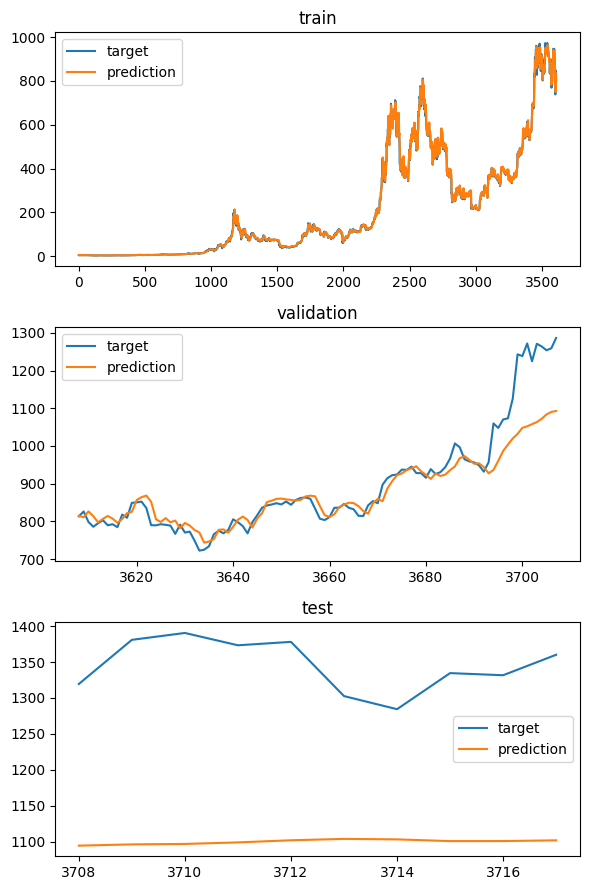

In [20]:
if __name__ == "__main__":
  parser = get_parser()
  # args = parser.parse_args()
  args = parser.parse_args([
      '--no-wandb',                    # wandb 비활성화 (False)
      '--batch_size', '2048',          # batch_size 기본값
      '--epochs', '10000',             # epochs 기본값 
      '--learning_rate', '0.0001',     # learning_rate 기본값 (1e-4)
      '--weight_decay', '0.0',         # weight_decay 기본값
      '--validation_intervals', '30',   # validation_intervals 기본값
      '--early_stop_patience', '30',   # early_stop_patience 기본값
      '--early_stop_delta', '0.000001' # early_stop_delta 기본값
  ])
  main(args)

##### _01_code/_15_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py

In [21]:
import torch
from torch import nn, optim
from datetime import datetime
import os
import wandb
from pathlib import Path

# BASE_PATH = str(Path(__file__).resolve().parent.parent.parent) # BASE_PATH: /Users/yhhan/git/link_dl
BASE_PATH = str(Path.cwd().parent.parent.parent)  # 현재 디렉토리 기준으로 부모 디렉토리 이동
print(BASE_PATH)

/data/2_data_server/nlp-05/KOREATECH/2024-2_DL/link_dl


In [22]:
import sys
sys.path.append(BASE_PATH)

In [23]:
# CURRENT_FILE_PATH = os.path.dirname(os.path.abspath(__file__))
CURRENT_FILE_PATH = str(Path.cwd())
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

In [24]:
from _01_code._08_fcn_best_practice.c_trainer import ClassificationTrainer
from _01_code._15_lstm_and_its_application.f_arg_parser import get_parser
# from _01_code._15_lstm_and_its_application.g_crypto_currency_regression_train_lstm import get_btc_krw_data

In [25]:
def get_model():
   class MyModel(nn.Module):
       def __init__(self, n_input, n_output):
           # MyModel 클래스 초기화 - 입력 차원과 출력 차원을 인자로 받음
           super().__init__()

           # LSTM 레이어 정의
           # input_size=n_input: 입력 피처 수
           # hidden_size=256: LSTM의 은닉 상태 크기
           # num_layers=3: LSTM 레이어 수
           # batch_first=True: 입력 텐서의 shape를 (batch, seq_len, features)로 설정
           self.lstm = nn.LSTM(input_size=n_input, hidden_size=256, num_layers=3, batch_first=True)
           
           # 전결합 레이어 정의
           # in_features=256: LSTM의 은닉 상태 크기와 동일
           # out_features=n_output: 최종 출력 차원
           self.fcn = nn.Linear(in_features=256, out_features=n_output)

       def forward(self, x):
           # LSTM 레이어를 통과
           # x: 입력 텐서
           # hidden: LSTM의 은닉 상태 (여기서는 사용하지 않음)
           x, hidden = self.lstm(x)
           
           # 마지막 시퀀스의 출력만 선택
           # x[:, -1, :]: 배치의 각 시퀀스의 마지막 타임스텝의 출력을 선택
           x = x[:, -1, :]  # x.shape: [32, 128]
           
           # 전결합 레이어를 통과하여 최종 출력 생성
           x = self.fcn(x)
           return x

   # 모델 인스턴스 생성
   # n_input=5: 입력 피처 수를 5로 설정
   # n_output=2: 출력 차원을 2로 설정
   my_model = MyModel(n_input=5, n_output=2)

   # 생성된 모델 반환
   return my_model

In [32]:
def main(args):
    # 현재 시간을 문자열로 변환하여 실험 구분에 사용
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    # wandb에서 추적할 하이퍼파라미터 설정
    config = {
        'epochs': args.epochs,                # 총 학습 에폭 수
        'batch_size': args.batch_size,        # 배치 크기
        'validation_intervals': args.validation_intervals,  # 검증을 수행할 간격
        'learning_rate': args.learning_rate,  # 학습률
        'early_stop_patience': args.early_stop_patience,  # 조기 종료를 위한 인내심
        'early_stop_delta': args.early_stop_delta,        # 조기 종료를 위한 최소 개선값
        'weight_decay': args.weight_decay     # L2 정규화 계수
    }

    # Weights & Biases 초기화
    project_name = "lstm_classification_btc_krw"
    wandb.init(
        mode="online" if args.wandb else "disabled",  # wandb 사용 여부 설정
        project=project_name,                         # 프로젝트 이름
        notes="btc_krw experiment with lstm",        # 실험 노트
        tags=["lstm", "classification", "btc_krw"],      # 실험 태그
        name=run_time_str,                           # 실험 이름(현재 시간 기반)
        config=config                                # 설정된 하이퍼파라미터
    )
    # 입력 인자와 wandb 설정 출력
    print(args)
    print(wandb.config)

    # 데이터 로더 생성 (테스트 데이터 로더는 현재 사용하지 않음)
    train_data_loader, validation_data_loader, _ = get_btc_krw_data(is_regression=False)
    
    # GPU 사용 가능 여부 확인 및 디바이스 설정
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training on device {device}.")

    # 모델 생성 및 지정된 디바이스로 이동
    model = get_model()
    model.to(device)

    # Adam 옵티마이저 설정
    # learning_rate와 weight_decay는 wandb config에서 가져옴
    optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

    classification_trainer = ClassificationTrainer(
        project_name, model, optimizer, train_data_loader, validation_data_loader, None,
        run_time_str, wandb, device, CHECKPOINT_FILE_PATH
    )
   
    # 학습 실행
    classification_trainer.train_loop()

    # wandb 실험 종료
    wandb.finish()

In [34]:
if __name__ == "__main__":
  parser = get_parser()
  # args = parser.parse_args()
  args = parser.parse_args([
      '--wandb',                       # wandb 활성화
      '-r', '0.00001',                 # learning_rate 수정
      '-p', '100',                     # early_stop_patience 수정
  ])
  main(args)
  # python _01_code/_11_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py -p 100 -r 0.00001

Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=1e-05, weight_decay=0.0, validation_intervals=30, early_stop_patience=100, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 1e-05, 'early_stop_patience': 100, 'early_stop_delta': 1e-06, 'weight_decay': 0.0}
Training on device cuda:0.
[Epoch   1] T_loss: 0.69243, T_accuracy: 52.7993 | V_loss: 0.69113, V_accuracy: 56.0000 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.69151, T_accuracy: 52.7993 | V_loss: 0.69034, V_accuracy: 56.0000 | V_loss decreased (0.69113 --> 0.69034). Saving model... | T_time: 00:00:00, T_speed: 0.000
[Epoch  60] T_loss: 0.69099, T_accuracy: 52.7993 | V_loss: 0.69176, V_accuracy: 55.0000 | Early stopping counter: 1 out of 100 | T_time: 00:00:01, T_speed: 60.000
[Epoch  90] T_loss: 0.69051, T_accuracy: 53.2428 | V_loss: 0.69514, V_accuracy: 44.0000 | Early stopping counter: 2 out of 100 | T_time: 00:00:02,

Epoch,▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
Training accuracy (%),▁▁▁█▆▇▆█▃▃▄▃▃▄▃▃▅▄▃▄▄▄▅▅▅▅▅▄▄▄▅▅▅▅▅▆▆▅██
Training loss,█▅▃▂▄▂▃▄▃▃▅▄▃▂▄▂▄▂▃▂▃▃▃▄▃▃▃▃▄▁▃▂▄▃▂▄▄▂▁▂
Training speed (epochs/sec.),█▄▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation accuracy (%),██▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation loss,▂▁▇██▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███▇▇████████▇
Epoch,3030
Training accuracy (%),53.29823
Training loss,0.69044
Training speed (epochs/sec.),34.82759
Validation accuracy (%),44


##### _01_code/_15_lstm_and_its_application/j_crypto_currency_classification_test_lstm.py

In [35]:
import torch
import os
from pathlib import Path
from datetime import datetime
import wandb

# BASE_PATH = str(Path(__file__).resolve().parent.parent.parent) # BASE_PATH: /Users/yhhan/git/link_dl
BASE_PATH = str(Path.cwd().parent.parent.parent)  # 현재 디렉토리 기준으로 부모 디렉토리 이동
print(BASE_PATH)

/data/2_data_server/nlp-05/KOREATECH/2024-2_DL/link_dl


In [36]:
import sys
sys.path.append(BASE_PATH)

In [37]:
# CURRENT_FILE_PATH = os.path.dirname(os.path.abspath(__file__))
CURRENT_FILE_PATH = str(Path.cwd())
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

In [38]:
from _01_code._15_lstm_and_its_application.f_arg_parser import get_parser
# from _01_code._15_lstm_and_its_application.g_crypto_currency_regression_train_lstm import get_btc_krw_data
# from _01_code._15_lstm_and_its_application.i_crypto_currency_classification_train_lstm import get_model

In [39]:
def test(test_model):
  _, _, test_data_loader = get_btc_krw_data(is_regression=False)

  test_model.eval()

  num_corrects_test = 0
  num_tested_samples = 0

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)

      predicted_test = torch.argmax(output_test, dim=1)
      num_corrects_test += torch.sum(torch.eq(predicted_test, target_test))

      num_tested_samples += len(input_test)

    test_accuracy = 100.0 * num_corrects_test / num_tested_samples

    print(f"TEST RESULTS: {test_accuracy:6.3f}%")

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f}".format(
        idx, torch.argmax(output).item(), target.item()
      ))

In [40]:
def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
  }

  project_name = "lstm_classification_btc_krw"
  wandb.init(
    mode="disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )

  test_model = get_model()

  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model)

In [41]:
if __name__ == "__main__":
  parser = get_parser()
  args = parser.parse_args([
      '--no-wandb',                    # wandb 비활성화 (False)
      '--batch_size', '2048',          # batch_size 기본값
      '--epochs', '10000',             # epochs 기본값 
      '--learning_rate', '0.0001',     # learning_rate 기본값 (1e-4)
      '--weight_decay', '0.0',         # weight_decay 기본값
      '--validation_intervals', '30',   # validation_intervals 기본값
      '--early_stop_patience', '30',   # early_stop_patience 기본값
      '--early_stop_delta', '0.000001' # early_stop_delta 기본값
  ])
  main(args)

MODEL FILE: /data/2_data_server/nlp-05/KOREATECH/2024-2_DL/link_dl/_03_your_code/CSE533/hw4/checkpoints/lstm_classification_btc_krw_checkpoint_latest.pt


/tmp/ipykernel_42112/510403193.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu'))

[TEST DATA]
TEST RESULTS: 60.000%
 0:   1.00 <-->   1.00
 1:   1.00 <-->   1.00
 2:   1.00 <-->   0.00
 3:   1.00 <-->   1.00
 4:   1.00 <-->   1.00
 5:   1.00 <-->   0.00
 6:   1.00 <-->   1.00
 7:   1.00 <-->   1.00
 8:   1.00 <-->   0.00
 9:   1.00 <-->   0.00


#### [문제 2] 적절한 새로운 모델 구성 및 하이퍼파라미터 찾기
- Classification 학습을 위한 데이터 관련 설정 값
    - sequence_size = 21, validation_size = 150, test_size = 30, is_regression = True

##### regression_train_lstm

In [77]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from datetime import datetime
import os
import wandb
from pathlib import Path

# BASE_PATH = str(Path(__file__).resolve().parent.parent.parent) # BASE_PATH: /Users/yhhan/git/link_dl
BASE_PATH = str(Path.cwd().parent.parent.parent)  # 현재 디렉토리 기준으로 부모 디렉토리 이동
print(BASE_PATH)

import sys
sys.path.append(BASE_PATH)

# CURRENT_FILE_PATH = os.path.dirname(os.path.abspath(__file__))
CURRENT_FILE_PATH = str(Path.cwd())
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

from _01_code._15_lstm_and_its_application.f_arg_parser import get_parser
from _01_code._14_rnn.g_rnn_trainer import RegressionTrainer
# from _01_code._03_real_world_data_to_tensors.p_cryptocurrency_dataset_dataloader import get_cryptocurrency_data, \
#   CryptoCurrencyDataset

def get_btc_krw_data(sequence_size=10, validation_size=100, test_size=10, is_regression=True):
   # 비트코인 가격 데이터를 학습/검증/테스트 세트로 분리하는 함수
   
   # 파라미터 설명:
   # sequence_size: 입력 시퀀스의 길이 (몇 일치 데이터를 보고 예측할지)
   # validation_size: 검증 데이터셋의 크기
   # test_size: 테스트 데이터셋의 크기 
   # is_regression: True이면 회귀 문제, False이면 분류 문제로 처리

   # get_cryptocurrency_data 함수를 호출하여 데이터 분할
   X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
       = get_cryptocurrency_data(
           sequence_size=sequence_size,
           validation_size=validation_size, 
           test_size=test_size,
           target_column='Close',  # 종가를 예측 타겟으로 사용
           y_normalizer=1.0e7,     # y값을 정규화하기 위한 스케일링 팩터
           is_regression=is_regression
       )

   # 반환되는 데이터 형태:
   # X_train.shape: [3212, 10, 5] - 3212개 샘플, 각 10일치 시퀀스, 5개 특성
   # X_validation.shape: [100, 10, 5] - 100개 검증 샘플
   # X_test.shape: [10, 10, 5] - 10개 테스트 샘플
   # y_train.shape: [3212] - 각 시퀀스에 대한 타겟값
   # y_validation.shape: [100]
   # y_test.shape: [10]

   # CryptoCurrencyDataset 클래스를 사용하여 PyTorch Dataset 객체 생성
   train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
   validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
   test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

   # DataLoader를 사용하여 배치 처리를 위한 이터레이터 생성
   train_data_loader = DataLoader(
       dataset=train_crypto_currency_dataset, 
       batch_size=wandb.config.batch_size,  # wandb에 설정된 배치 크기 사용
       shuffle=True  # 매 에폭마다 데이터 순서를 섞음
   )
   
   validation_data_loader = DataLoader(
       dataset=validation_crypto_currency_dataset,
       batch_size=wandb.config.batch_size,
       shuffle=True
   )
   
   test_data_loader = DataLoader(
       dataset=test_crypto_currency_dataset,
       batch_size=len(test_crypto_currency_dataset),  # 테스트는 전체 데이터를 한 번에 처리
       shuffle=True
   )

   # 생성된 DataLoader 객체들 반환
   return train_data_loader, validation_data_loader, test_data_loader

def get_model():
   # LSTM과 FCN을 결합한 시계열 예측 모델 클래스 정의
   class MyModel(nn.Module):
       def __init__(self, n_input, n_output):
           # n_input: 입력 특성의 수 (여기서는 5개: Open, High, Low, Close, Volume 등)
           # n_output: 출력값의 수 (여기서는 1개: 다음 날의 종가 예측)
           super().__init__()

           # LSTM 레이어 정의
           self.lstm = nn.LSTM(
               input_size=n_input,     # 입력 특성 수
               hidden_size=128,        # LSTM의 은닉 상태 크기
               num_layers=2,           ## LSTM layers 그대로로
               batch_first=True,       # 입력 텐서의 형태가 [batch_size, sequence_length, n_input]
               dropout=0.2             ## Dropout 적용
           )

           # 완전연결층(Fully Connected Layer) 정의
           self.fcn = nn.Linear(
               in_features=128,        # LSTM의 은닉 상태 크기와 동일
               out_features=n_output   # 출력값의 수 (예측값)
           )

       def forward(self, x):
           # x의 예상되는 입력 shape: [batch_size, sequence_length, n_input]
           
           # LSTM 레이어 통과
           # x: LSTM의 출력값, hidden: 마지막 은닉 상태와 셀 상태
           x, hidden = self.lstm(x)
           # x의 shape: [batch_size, sequence_length, hidden_size]

           # 마지막 시점의 출력만 선택
           x = x[:, -1, :]  
           # x의 shape: [batch_size, hidden_size]
           # [:, -1, :]: 모든 배치(-1 인덱스)의 마지막 시점 출력을 선택

           # 완전연결층을 통과시켜 최종 예측값 생성
           x = self.fcn(x)
           # x의 shape: [batch_size, n_output]

           return x

   # 모델 인스턴스 생성
   # n_input=5: 입력 특성 5개
   # n_output=1: 예측값 1개 (다음 날의 종가)
   my_model = MyModel(n_input=5, n_output=1)

   return my_model


/data/2_data_server/nlp-05/KOREATECH/2024-2_DL/link_dl


In [78]:
def main(args):
    # 현재 시간을 문자열로 변환하여 실험 구분에 사용
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    # wandb에서 추적할 하이퍼파라미터 설정
    config = {
        'epochs': args.epochs,                # 총 학습 에폭 수
        'batch_size': args.batch_size,        # 배치 크기
        'validation_intervals': args.validation_intervals,  # 검증을 수행할 간격
        'learning_rate': args.learning_rate,  # 학습률
        'early_stop_patience': args.early_stop_patience,  # 조기 종료를 위한 인내심
        'early_stop_delta': args.early_stop_delta,        # 조기 종료를 위한 최소 개선값
        'weight_decay': args.weight_decay     # L2 정규화 계수
    }

    # Weights & Biases 초기화
    project_name = "lstm_regression_btc_krw"
    wandb.init(
        mode="online" if args.wandb else "disabled",  # wandb 사용 여부 설정
        project=project_name,                         # 프로젝트 이름
        notes="btc_krw experiment with lstm",        # 실험 노트
        tags=["lstm", "regression", "btc_krw"],      # 실험 태그
        name=run_time_str,                           # 실험 이름(현재 시간 기반)
        config=config                                # 설정된 하이퍼파라미터
    )
    # 입력 인자와 wandb 설정 출력
    print(args)
    print(wandb.config)

    # wandb.config에 args 값을 업데이트
    wandb.config.update(args.__dict__)

    # 데이터 로더 생성 (테스트 데이터 로더는 현재 사용하지 않음)
    train_data_loader, validation_data_loader, _ = get_btc_krw_data()
    
    # GPU 사용 가능 여부 확인 및 디바이스 설정
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training on device {device}.")

    # 모델 생성 및 지정된 디바이스로 이동
    model = get_model()
    model.to(device)

    # Adam 옵티마이저 설정
    # learning_rate와 weight_decay는 wandb config에서 가져옴
    optimizer = optim.Adam(
        model.parameters(), 
        lr=wandb.config.learning_rate, 
        weight_decay=wandb.config.weight_decay
    )

    # 회귀 학습을 위한 트레이너 객체 생성
    regression_trainer = RegressionTrainer(
        project_name,              # 프로젝트 이름
        model,                     # 학습할 모델
        optimizer,                 # 옵티마이저
        train_data_loader,         # 학습 데이터 로더
        validation_data_loader,    # 검증 데이터 로더
        None,                      # 테스트 데이터 로더(사용하지 않음)
        run_time_str,             # 실험 구분을 위한 시간 문자열
        wandb,                     # wandb 객체
        device,                    # 학습 디바이스
        CHECKPOINT_FILE_PATH       # 체크포인트 저장 경로
    )
    
    # 학습 실행
    regression_trainer.train_loop()

    # wandb 실험 종료
    wandb.finish()

In [79]:
if __name__ == "__main__":
    import argparse

    # ArgumentParser 생성 및 플래그 추가
    parser = argparse.ArgumentParser(description="LSTM regression trainer arguments")
    
    parser.add_argument('--wandb', action='store_true', help='Weights & Biases 사용 여부')
    parser.add_argument('--epochs', type=int, default=10_000, help='총 학습 에폭 수')
    parser.add_argument('--batch_size', type=int, default=2048, help='배치 크기')
    parser.add_argument('--validation_intervals', type=int, default=30, help='검증을 수행할 간격')
    parser.add_argument('--learning_rate', type=float, default=1e-4, help='학습률')
    parser.add_argument('--early_stop_patience', type=int, default=30, help='조기 종료를 위한 인내심')
    parser.add_argument('--early_stop_delta', type=float, default=0.000001, help='조기 종료를 위한 최소 개선값')
    parser.add_argument('--weight_decay', type=float, default=0.0, help='L2 정규화 계수')
    
    # 지정된 순서대로 args를 생성
    args = parser.parse_args([
        '--wandb',
        '--batch_size', '2048',
        '--validation_intervals', '30',
        '--learning_rate', '0.0001',
        '--early_stop_patience', '30',
        '--early_stop_delta', '1e-06',
        '--weight_decay', '1e-04'
    ])

    # args 출력 확인
    print(args)

    # main 함수 호출
    main(args)

Namespace(wandb=True, epochs=10000, batch_size=2048, validation_intervals=30, learning_rate=0.0001, early_stop_patience=30, early_stop_delta=1e-06, weight_decay=0.0001)


Namespace(wandb=True, epochs=10000, batch_size=2048, validation_intervals=30, learning_rate=0.0001, early_stop_patience=30, early_stop_delta=1e-06, weight_decay=0.0001)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0.0001}
Training on device cuda:0.
[Epoch   1] T_loss: 10.61363, V_loss: 81.14098, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.036
[Epoch  30] T_loss: 7.13531, V_loss: 52.97094, V_loss decreased (81.14098 --> 52.97094). Saving model... | T_time: 00:00:00, T_speed: 0.039
[Epoch  60] T_loss: 0.72913, V_loss: 11.44549, V_loss decreased (52.97094 --> 11.44549). Saving model... | T_time: 00:00:01, T_speed: 0.104
[Epoch  90] T_loss: 0.37553, V_loss: 7.40900, V_loss decreased (11.44549 --> 7.40900). Saving model... | T_time: 00:00:02, T_speed: 0.236
[Epoch 120] T_loss: 0.26352, V_loss: 5.23286, V_loss decreased (7.40900 --> 5.23286). Saving model... | T_ti

Epoch,▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇██
Training loss,█▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▁▁▁▁▂▇▁▁▁▂▁▁▁█▁▂▂▂▃▁▁▁▁▂▁▂▁▁▂▁▂▅▁▂▁▁▂▂▁
Validation loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,5850
Training loss,0.01282
Training speed (epochs/sec.),6.34705
Validation loss,0.33703


- 가장 학습이 잘 되는 모델 구성 및 하이퍼파라미터 값
    - LSTM layers의 개수: 2개(수정 없이 그대로)
    - Linear layers의 개수: 1개(수정 없이 그대로)
    - Weight Decay: 1e−4
    - Dropout Rate: 0.2

##### regression_test_lstm

In [84]:
import torch
import wandb
from matplotlib import pyplot as plt
from datetime import datetime
import os
from pathlib import Path

# BASE_PATH = str(Path(__file__).resolve().parent.parent.parent) # BASE_PATH: /Users/yhhan/git/link_dl
BASE_PATH = str(Path.cwd().parent.parent.parent)  # 현재 디렉토리 기준으로 부모 디렉토리 이동
print(BASE_PATH)

import sys
sys.path.append(BASE_PATH)

# CURRENT_FILE_PATH = os.path.dirname(os.path.abspath(__file__))
CURRENT_FILE_PATH = str(Path.cwd())
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

def test(test_model):
    # test_model을 매개변수로 받는 테스트 함수 정의
    
    _, _, test_data_loader = get_btc_krw_data()
    # BTC/KRW 데이터를 로드하는 함수를 호출하여 테스트 데이터 로더만 사용
    # 앞의 두 값은 무시하고 세 번째 값(test_data_loader)만 가져옴

    test_model.eval()
    # 모델을 평가 모드로 설정 (학습 모드가 아닌 추론 모드)
    # dropout, batch normalization 등이 평가 모드로 동작하게 됨

    y_normalizer = 100
    # 출력값을 정규화하기 위한 스케일링 팩터 설정

    print("[TEST DATA]")
    with torch.no_grad():
        # gradient 계산을 비활성화하여 메모리 사용량 감소 및 연산 속도 향상
        for test_batch in test_data_loader:
            # 테스트 데이터 로더에서 배치 단위로 데이터를 가져옴
            input_test, target_test = test_batch
            # 배치에서 입력 데이터와 정답 데이터를 분리

            output_test = test_model(input_test)
            # 모델에 테스트 입력 데이터를 통과시켜 예측값 생성

        for idx, (output, target) in enumerate(zip(output_test, target_test)):
            # 예측값과 실제값을 순회하면서 각각의 결과를 출력
            print("{0:2}: {1:6,.2f} <--> {2:6,.2f} (Loss: {3:>13,.2f})".format(
                idx,                                            # 인덱스
                output.item() * y_normalizer,                   # 정규화된 예측값
                target.item() * y_normalizer,                   # 정규화된 실제값
                abs(output.squeeze(dim=-1).item() - target.item()) * y_normalizer  # 절대 오차
            ))
            # 포맷팅된 문자열로 결과를 출력:
            # - 인덱스는 2자리
            # - 예측값과 실제값은 소수점 둘째자리까지 표시하고 천 단위 구분자 사용
            # - Loss는 우측 정렬하여 13자리로 표시

def predict_all(test_model):
   # 예측값의 정규화를 위한 스케일링 팩터 설정
   y_normalizer = 100

   # 암호화폐 데이터를 가져와서 train/validation/test 세트로 분할
   # sequence_size=10: 입력 시퀀스 길이
   # validation_size=100: 검증 세트 크기
   # test_size=10: 테스트 세트 크기
   # target_column='Close': 종가를 예측 대상으로 설정
   # y_normalizer=1.0e7: 타겟값 정규화 스케일링 팩터
   # is_regression=True: 회귀 문제로 설정
   X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
       = get_cryptocurrency_data(
           sequence_size=10, validation_size=100, test_size=10,
           target_column='Close', y_normalizer=1.0e7, is_regression=True
       )

   # 각 데이터셋에 대한 CryptoCurrencyDataset 객체 생성
   train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
   validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
   test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

   # 데이터셋과 레이블을 리스트로 묶음
   dataset_list = [
       train_crypto_currency_dataset, validation_crypto_currency_dataset, test_crypto_currency_dataset
   ]
   dataset_labels = [
       "train", "validation", "test"
   ]
   
   # x축 값 초기화
   num = 0
   # 3개의 서브플롯을 가진 figure 생성 (6x9 크기)
   fig, axs = plt.subplots(3, 1, figsize=(6, 9))

   # 각 데이터셋(train/validation/test)에 대해 반복
   for i in range(3):
       # 그래프 그리기 위한 데이터 저장용 리스트
       X = []          # x축 값
       TARGET_Y = []   # 실제 타겟값
       PREDICTION_Y = [] # 예측값
       
       # 현재 데이터셋의 각 데이터에 대해 반복
       for data in dataset_list[i]:
           input, target = data
           # 모델 예측 수행 (배치 차원 추가 후 예측하고 다시 제거)
           prediction = test_model(input.unsqueeze(0)).squeeze(-1).squeeze(-1)

           # 그래프 데이터 추가
           X.append(num)
           TARGET_Y.append(target.item() * y_normalizer)
           PREDICTION_Y.append(prediction.item() * y_normalizer)
           
           num += 1

       # i번째 서브플롯에 타겟값과 예측값 그래프 그리기
       axs[i].plot(X, TARGET_Y, label='target')
       axs[i].plot(X, PREDICTION_Y, label='prediction')
       axs[i].set_title(dataset_labels[i])
       axs[i].legend()

   # 서브플롯 간 간격 자동 조정
   plt.tight_layout()
   # 그래프 표시
   plt.show()

/data/2_data_server/nlp-05/KOREATECH/2024-2_DL/link_dl


MODEL FILE: /data/2_data_server/nlp-05/KOREATECH/2024-2_DL/link_dl/_03_your_code/CSE533/hw4/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt


/tmp/ipykernel_42112/3274596096.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')

[TEST DATA]
 0: 1,116.04 <--> 1,360.09 (Loss:        244.06)
 1: 1,105.22 <--> 1,319.45 (Loss:        214.23)
 2: 1,117.85 <--> 1,390.43 (Loss:        272.58)
 3: 1,122.02 <--> 1,378.05 (Loss:        256.03)
 4: 1,109.84 <--> 1,334.58 (Loss:        224.74)
 5: 1,109.98 <--> 1,380.87 (Loss:        270.89)
 6: 1,115.17 <--> 1,331.62 (Loss:        216.45)
 7: 1,122.94 <--> 1,302.60 (Loss:        179.66)
 8: 1,120.79 <--> 1,373.29 (Loss:        252.50)
 9: 1,115.56 <--> 1,284.38 (Loss:        168.82)


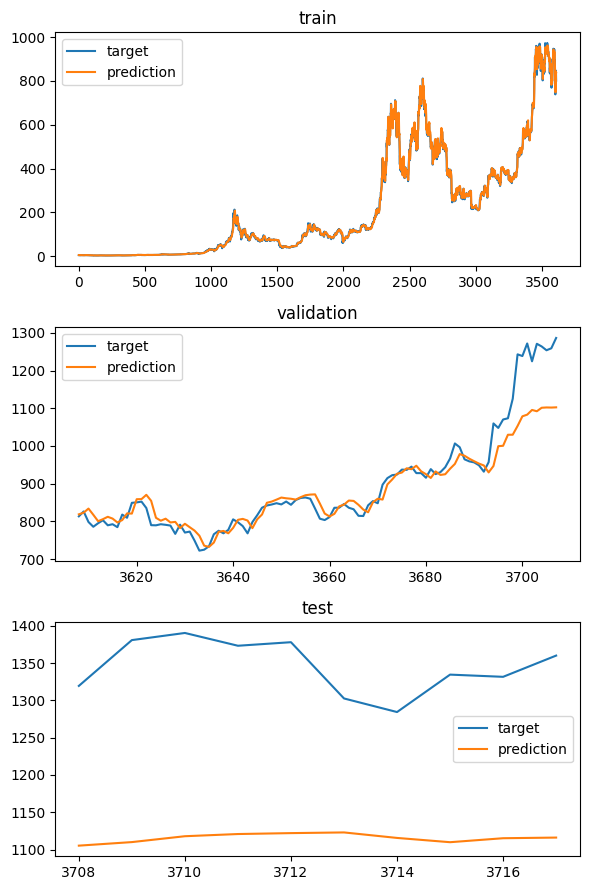

In [86]:
def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
  }

  project_name = "lstm_regression_btc_krw"
  wandb.init(
    mode="disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )

  test_model = get_model()

  project_name = "lstm_regression_btc_krw"
  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model)
  predict_all(test_model)

if __name__ == "__main__":
  parser = get_parser()
  # args = parser.parse_args()
  args = parser.parse_args([
    '--no-wandb',
    '--batch_size', '2048',
    '--validation_intervals', '30',
    '--learning_rate', '0.0001',
    '--early_stop_patience', '30',
    '--early_stop_delta', '1e-06',
    '--weight_decay', '1e-04'
  ])
  main(args)

##### classification_train_lstm.py

In [88]:
import torch
from torch import nn, optim
from datetime import datetime
import os
import wandb
from pathlib import Path

# BASE_PATH = str(Path(__file__).resolve().parent.parent.parent) # BASE_PATH: /Users/yhhan/git/link_dl
BASE_PATH = str(Path.cwd().parent.parent.parent)  # 현재 디렉토리 기준으로 부모 디렉토리 이동
print(BASE_PATH)

import sys
sys.path.append(BASE_PATH)

# CURRENT_FILE_PATH = os.path.dirname(os.path.abspath(__file__))
CURRENT_FILE_PATH = str(Path.cwd())
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

from _01_code._08_fcn_best_practice.c_trainer import ClassificationTrainer

def get_model():
   class MyModel(nn.Module):
       def __init__(self, n_input, n_output):
           # MyModel 클래스 초기화 - 입력 차원과 출력 차원을 인자로 받음
           super().__init__()

           # LSTM 레이어 정의
           # input_size=n_input: 입력 피처 수
           # hidden_size=256: LSTM의 은닉 상태 크기
           # num_layers=3: LSTM 레이어 수
           # batch_first=True: 입력 텐서의 shape를 (batch, seq_len, features)로 설정
           self.lstm = nn.LSTM(input_size=n_input, hidden_size=256, num_layers=3, batch_first=True, dropout=0.3)
           
           # 전결합 레이어 정의
           # in_features=256: LSTM의 은닉 상태 크기와 동일
           # out_features=n_output: 최종 출력 차원
           self.fcn = nn.Linear(in_features=256, out_features=n_output)

       def forward(self, x):
           # LSTM 레이어를 통과
           # x: 입력 텐서
           # hidden: LSTM의 은닉 상태 (여기서는 사용하지 않음)
           x, hidden = self.lstm(x)
           
           # 마지막 시퀀스의 출력만 선택
           # x[:, -1, :]: 배치의 각 시퀀스의 마지막 타임스텝의 출력을 선택
           x = x[:, -1, :]  # x.shape: [32, 128]
           
           # 전결합 레이어를 통과하여 최종 출력 생성
           x = self.fcn(x)
           return x

   # 모델 인스턴스 생성
   # n_input=5: 입력 피처 수를 5로 설정
   # n_output=2: 출력 차원을 2로 설정
   my_model = MyModel(n_input=5, n_output=2)

   # 생성된 모델 반환
   return my_model

/data/2_data_server/nlp-05/KOREATECH/2024-2_DL/link_dl


In [98]:
def main(args):
    # 현재 시간을 문자열로 변환하여 실험 구분에 사용
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    # wandb에서 추적할 하이퍼파라미터 설정
    config = {
        'epochs': args.epochs,                # 총 학습 에폭 수
        'batch_size': args.batch_size,        # 배치 크기
        'validation_intervals': args.validation_intervals,  # 검증을 수행할 간격
        'learning_rate': args.learning_rate,  # 학습률
        'early_stop_patience': args.early_stop_patience,  # 조기 종료를 위한 인내심
        'early_stop_delta': args.early_stop_delta,        # 조기 종료를 위한 최소 개선값
        'weight_decay': args.weight_decay     # L2 정규화 계수
    }

    # Weights & Biases 초기화
    project_name = "lstm_classification_btc_krw"
    wandb.init(
        mode="online" if args.wandb else "disabled",  # wandb 사용 여부 설정
        project=project_name,                         # 프로젝트 이름
        notes="btc_krw experiment with lstm",        # 실험 노트
        tags=["lstm", "classification", "btc_krw"],      # 실험 태그
        name=run_time_str,                           # 실험 이름(현재 시간 기반)
        config=config                                # 설정된 하이퍼파라미터
    )
    # 입력 인자와 wandb 설정 출력
    print(args)
    print(wandb.config)

    # wandb.config에 args 값을 업데이트
    wandb.config.update(args.__dict__)

    # 데이터 로더 생성 (테스트 데이터 로더는 현재 사용하지 않음)
    train_data_loader, validation_data_loader, _ = get_btc_krw_data(is_regression=False)
    
    # GPU 사용 가능 여부 확인 및 디바이스 설정
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training on device {device}.")

    # 모델 생성 및 지정된 디바이스로 이동
    model = get_model()
    model.to(device)

    # Adam 옵티마이저 설정
    # learning_rate와 weight_decay는 wandb config에서 가져옴
    optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

    classification_trainer = ClassificationTrainer(
        project_name, model, optimizer, train_data_loader, validation_data_loader, None,
        run_time_str, wandb, device, CHECKPOINT_FILE_PATH
    )
   
    # 학습 실행
    classification_trainer.train_loop()

    # wandb 실험 종료
    wandb.finish()

In [99]:
# if __name__ == "__main__":
#     import argparse

#     # ArgumentParser 생성 및 플래그 추가
#     parser = argparse.ArgumentParser(description="LSTM classification trainer arguments")
    
#     parser.add_argument('--wandb', action='store_true', help='Weights & Biases 사용 여부')
#     parser.add_argument('--epochs', type=int, default=10_000, help='총 학습 에폭 수')
#     parser.add_argument('--batch_size', type=int, default=2048, help='배치 크기')
#     parser.add_argument('--validation_intervals', type=int, default=30, help='검증을 수행할 간격')
#     parser.add_argument('--learning_rate', type=float, default=1e-4, help='학습률')
#     parser.add_argument('--early_stop_patience', type=int, default=30, help='조기 종료를 위한 인내심')
#     parser.add_argument('--early_stop_delta', type=float, default=0.000001, help='조기 종료를 위한 최소 개선값')
#     parser.add_argument('--weight_decay', type=float, default=0.0, help='L2 정규화 계수')
    
#     # 지정된 순서대로 args를 생성
#     args = parser.parse_args([
#         '--wandb',
#         '--batch_size', '2048',
#         '--validation_intervals', '30',
#         '--learning_rate', '0.0001',
#         '--early_stop_patience', '30',
#         '--early_stop_delta', '1e-06',
#         '--weight_decay', '1e-4'
#     ])

#     # args 출력 확인
#     print(args)

#     # main 함수 호출
#     main(args)

if __name__ == "__main__":
  parser = get_parser()
  # args = parser.parse_args()
  args = parser.parse_args([
      '--wandb',                       # wandb 활성화
      '-r', '0.00001',                 # learning_rate 수정
      '-p', '100',                     # early_stop_patience 수정
      '-w', '1e-4',
  ])
  main(args)

Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=1e-05, weight_decay=0.0001, validation_intervals=30, early_stop_patience=100, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 1e-05, 'early_stop_patience': 100, 'early_stop_delta': 1e-06, 'weight_decay': 0.0001}
Training on device cuda:0.
[Epoch   1] T_loss: 0.69403, T_accuracy: 47.2007 | V_loss: 0.69494, V_accuracy: 44.0000 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.69247, T_accuracy: 52.7439 | V_loss: 0.69282, V_accuracy: 55.0000 | V_loss decreased (0.69494 --> 0.69282). Saving model... | T_time: 00:00:00, T_speed: 0.000
[Epoch  60] T_loss: 0.69154, T_accuracy: 52.7993 | V_loss: 0.69186, V_accuracy: 56.0000 | V_loss decreased (0.69282 --> 0.69186). Saving model... | T_time: 00:00:01, T_speed: 60.000
[Epoch  90] T_loss: 0.69127, T_accuracy: 52.8825 | V_loss: 0.69217, V_accuracy: 53.0000 | Early stopping counter: 1 out o

Epoch,▁▁▁▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇██
Training accuracy (%),▁▇▇▇████████████▇███████████████████████
Training loss,█▅▃▂▂▁▁▂▁▁▂▂▂▂▂▂▂▂▁▁▁▂▁▂▁▁▂▁▁▁▂▁▁▁▂▁▁▁▁▁
Training speed (epochs/sec.),▁█▇▇▆▆▆▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
Validation accuracy (%),▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation loss,▄▁█████████████▇███▇███▇▇██▇▇███▇▇███▇█▇
Epoch,3060
Training accuracy (%),53.13193
Training loss,0.69066
Training speed (epochs/sec.),34
Validation accuracy (%),44


- 가장 학습이 잘 되는 모델 구성 및 하이퍼파라미터 값
    - LSTM layers의 개수: 2개(수정 없이 그대로)
    - Linear layers의 개수: 1개(수정 없이 그대로)
    - Weight Decay: 1e−4
    - Dropout Rate: 0.3

##### classification_test_lstm

In [101]:
import torch
import os
from pathlib import Path
from datetime import datetime
import wandb

# BASE_PATH = str(Path(__file__).resolve().parent.parent.parent) # BASE_PATH: /Users/yhhan/git/link_dl
BASE_PATH = str(Path.cwd().parent.parent.parent)  # 현재 디렉토리 기준으로 부모 디렉토리 이동
print(BASE_PATH)

import sys
sys.path.append(BASE_PATH)

# CURRENT_FILE_PATH = os.path.dirname(os.path.abspath(__file__))
CURRENT_FILE_PATH = str(Path.cwd())
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

from _01_code._15_lstm_and_its_application.f_arg_parser import get_parser
# from _01_code._15_lstm_and_its_application.g_crypto_currency_regression_train_lstm import get_btc_krw_data
# from _01_code._15_lstm_and_its_application.i_crypto_currency_classification_train_lstm import get_model

def test(test_model):
  _, _, test_data_loader = get_btc_krw_data(is_regression=False)

  test_model.eval()

  num_corrects_test = 0
  num_tested_samples = 0

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)

      predicted_test = torch.argmax(output_test, dim=1)
      num_corrects_test += torch.sum(torch.eq(predicted_test, target_test))

      num_tested_samples += len(input_test)

    test_accuracy = 100.0 * num_corrects_test / num_tested_samples

    print(f"TEST RESULTS: {test_accuracy:6.3f}%")

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f}".format(
        idx, torch.argmax(output).item(), target.item()
      ))

/data/2_data_server/nlp-05/KOREATECH/2024-2_DL/link_dl


In [103]:
def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
  }

  project_name = "lstm_classification_btc_krw"
  wandb.init(
    mode="disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )

  test_model = get_model()

  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model)

if __name__ == "__main__":
  parser = get_parser()
  args = parser.parse_args([
      '--no-wandb',                    # wandb 비활성화 (False)
      '--batch_size', '2048',          # batch_size 기본값
      '--epochs', '10000',             # epochs 기본값 
      '--learning_rate', '0.00001',     # learning_rate 기본값 (1e-4)
      '--weight_decay', '0.0001',         
      '--validation_intervals', '30',   # validation_intervals 기본값
      '--early_stop_patience', '100',   # early_stop_patience 기본값
      '--early_stop_delta', '0.000001' # early_stop_delta 기본값
  ])
  main(args)

MODEL FILE: /data/2_data_server/nlp-05/KOREATECH/2024-2_DL/link_dl/_03_your_code/CSE533/hw4/checkpoints/lstm_classification_btc_krw_checkpoint_latest.pt


/tmp/ipykernel_42112/138346085.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu'))

[TEST DATA]
TEST RESULTS: 40.000%
 0:   0.00 <-->   1.00
 1:   0.00 <-->   1.00
 2:   0.00 <-->   0.00
 3:   0.00 <-->   1.00
 4:   0.00 <-->   1.00
 5:   0.00 <-->   1.00
 6:   0.00 <-->   0.00
 7:   0.00 <-->   0.00
 8:   0.00 <-->   1.00
 9:   0.00 <-->   0.00


#### [문제 3] 데이터 Feature 추가 후 성능 변화 확인하기

진행하지 못함

# 숙제 후기

- lstm을 regression과 classification task를 진행해보면서 어느 값이 최적의 값인지 확인할 수 있었음
- 마지막 문제인 3도 진행했으면 좋았겠으나 진행하지 못해 매우 아쉬움